# LSTM Model Design, Building, and Training

This notebook focuses on designing, building, and training our predictive model for 5-day stock return direction.

We leverage the engineered dataset with fundamentals (`engine_final_allfeatures_wfund.csv`) and focus on the top 20 predictive features identified by XGBoost in the previous notebook.

The model is an LSTM built from scratch using TensorFlow/Keras to meet the project requirement for a neural network model developed end-to-end.

We will:

- Load data and features
- Prepare input sequences for the LSTM
- Build the LSTM architecture
- Train the model on sliding time windows
- Evaluate model performance on out-of-sample windows



## 1a. Ensuring Reproducibility and Consistent Results

To make sure our model training is consistent across runs, we fix all random seeds used in Python, NumPy, and TensorFlow. This helps eliminate variability caused by randomness in data shuffling, weight initialization, and other stochastic processes.

Additionally, we enable GPU memory growth to prevent TensorFlow from allocating all GPU memory upfront, which can improve stability when running multiple experiments or sharing a GPU environment.

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

# Set Python hash seed environment variable
os.environ['PYTHONHASHSEED'] = '42'

# Set Python built-in pseudo-random generator seed
random.seed(42)

# Set NumPy pseudo-random generator seed
np.random.seed(42)

# Set TensorFlow pseudo-random generator seed
tf.random.set_seed(42)

# Enable GPU memory growth for more stable multi-experiment runs
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Enable mixed precision to speed up training on A100 or L4 GPUs
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


## 1b. Loading Data and Feature List

We load the fully engineered dataset (including fundamental features) from disk, along with the list of top 20 features selected via XGBoost. These will be the inputs for our model training pipeline.

The dataset shape and feature list are printed to confirm successful loading and to get a sense of the input dimensionality.

In [2]:
import pandas as pd

# Load full feature dataset with fundamentals
df = pd.read_csv('engine_final_allfeatures_wfund.csv', parse_dates=['date'])

# Load top 20 features from previous XGBoost run
top20_features = pd.read_csv('top20_features_xgb.csv', skiprows=1, header=None).iloc[:,0].tolist()

print(f"Loaded dataset shape: {df.shape}")
print(f"Top 20 features:\n{top20_features}")


Loaded dataset shape: (202771, 52)
Top 20 features:
['vix_close', 'XLE_ret_5d', 'vix_return_1d', 'vix_vol_10', 'XLK_ret_5d', 'XLP_ret_5d', 'XLF_ret_5d', 'XLI_ret_5d', 'XLY_ret_5d', 'XLRE_ret_5d', 'XLV_ret_5d', 'XLU_ret_5d', 'XLB_ret_5d', 'XLC_ret_5d', 'donchian_low_20', 'return_21d', 'momentum_10', 'beta_60d', 'excess_return_5d', 'market_cap']


## 2. Preparing Training and Validation Sets

We exclude the SPY ticker since it is our benchmark index and not a stock to predict.

We’ll focus on the top 20 features identified by XGBoost as the inputs. The target variable is the 5-day future return, which we want to predict.

To keep our model honest, we split the data into training and validation sets randomly with an 80/20 split, ensuring good coverage across tickers and dates.

Since XGBoost required filling NaNs, we do the same here by replacing missing values with median values from the training data.

This sets up clean, consistent inputs for the neural network training.


In [3]:
from sklearn.model_selection import train_test_split

# Remove SPY rows to focus on individual stocks
train_df = df[df['final_ticker'] != 'SPY'].copy()

# Filter features present in DataFrame and target
feature_cols_final = [col for col in top20_features if col in train_df.columns]
X = train_df[feature_cols_final]
y = train_df['future_return_5d']

# Fill missing values with column medians to avoid issues in training
X = X.fillna(X.median())

# Create training and validation splits
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")


Training set shape: (162216, 20)
Validation set shape: (40555, 20)


## 3. Defining the LSTM Model Architecture

Our LSTM model processes sequences of historical feature vectors to capture temporal dependencies.

- Input shape corresponds to a sequence length of 10 days and the number of features.
- A single LSTM layer with 32 units and ReLU activation summarizes the temporal information.
- A Dense layer with sigmoid activation outputs a probability for the positive direction of the 5-day future return.
- We use binary cross-entropy loss for classification of directional movement.
- The RMSProp optimizer with a small learning rate is chosen for stable convergence.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import RMSprop

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid', dtype='float32'))  # output in float32 to avoid mixed precision issues
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.001))
    return model


## 4. Generating Sequences for LSTM Training

Since LSTMs require sequences of time steps as input, we create sliding windows of 10 days of feature vectors.

Each sequence corresponds to features from the previous 10 days, with a label of the direction (up/down) of the 5-day future return on the last day.

This transforms our tabular data into time series format, enabling the LSTM to learn temporal patterns.


In [5]:
def create_sequences(X, y, window_size=10):
    sequences, labels = [], []
    for i in range(window_size, len(X)):
        sequences.append(X[i-window_size:i, :])
        labels.append(y[i])
    return np.array(sequences), np.array(labels)


## 5. Encoding the Target Variable

For classification, we define the target label as 1 if the 5-day future return is positive, and 0 otherwise.

We clip extreme returns to ±20% to reduce noise and stabilize training.

This binary classification framework simplifies model outputs to directional predictions.


In [6]:
# Clip extreme returns for stability
df['future_return_5d'] = df['future_return_5d'].clip(-0.2, 0.2)

# Create binary target: 1 if return > 0 else 0
df['target_dir'] = (df['future_return_5d'] > 0).astype(int)


## 6. Training the LSTM Model with Sliding Window Cross-Validation

We implement a sliding window approach to simulate realistic model training and evaluation over time.

- Each window uses 252 trading days (approx. 1 year) for training, followed by 63 days (approx. 1 quarter) for validation.
- This simulates a rolling, walk-forward training process, which is closer to live deployment.
- Early stopping prevents overfitting by halting training when validation loss plateaus.
- We track key classification metrics (accuracy, precision, recall, F1) and compute cumulative returns for the strategy vs. market.


In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def sliding_window_train_eval(df, features, window_train=252, window_test=63, window_stride=63, sequence_length=10):
    unique_dates = sorted(df['date'].unique())
    results = []
    outlier_windows = []

    for start in range(0, len(unique_dates) - window_train - window_test, window_stride):
        # Define train and test date ranges for this sliding window
        train_dates = unique_dates[start:start + window_train]
        test_dates = unique_dates[start + window_train:start + window_train + window_test]

        # Subset the data for train and test periods
        train_df = df[df['date'].isin(train_dates)]
        test_df = df[df['date'].isin(test_dates)]

        # Extract features and targets for train/test
        X_train = train_df[features].values
        y_train = train_df['target_dir'].values
        X_test = test_df[features].values
        y_test = test_df['target_dir'].values

        # Scale features so they’re centered and comparable
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Prepare sequences for LSTM input shape (samples, time steps, features)
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size=sequence_length)
        X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, window_size=sequence_length)

        # Build the LSTM model with input shape matching our sequence size
        model = create_lstm_model(input_shape=(sequence_length, len(features)))

        # Train model with early stopping so we don’t overfit
        history = model.fit(
            X_train_seq, y_train_seq,
            validation_data=(X_test_seq, y_test_seq),
            epochs=30,
            batch_size=64,
            callbacks=[early_stop],
            verbose=0
        )

        # Predict probabilities on the test sequences
        pred_probs = model.predict(X_test_seq).flatten()

        # Turn probabilities into binary directional predictions at 0.5 threshold
        preds_binary = (pred_probs > 0.5).astype(int)

        # Calculate classification metrics for quick performance check
        accuracy = accuracy_score(y_test_seq, preds_binary)
        precision = precision_score(y_test_seq, preds_binary)
        recall = recall_score(y_test_seq, preds_binary)
        f1 = f1_score(y_test_seq, preds_binary)

        # Only trade when model is confident (above 0.55 long, below 0.45 short)
        trade_signals = np.where(pred_probs > 0.55, 1, np.where(pred_probs < 0.45, -1, 0))

        # Align actual future returns with our sequence length offset
        test_returns = test_df['future_return_5d'].iloc[sequence_length:].values

        # Calculate strategy returns applying our trade signals
        strategy_returns = trade_signals * test_returns

        # Clean NaNs and clip to avoid crazy returns skewing metrics
        strategy_returns = np.nan_to_num(strategy_returns, nan=0.0, posinf=0.0, neginf=0.0)
        test_returns = np.nan_to_num(test_returns, nan=0.0, posinf=0.0, neginf=0.0)

        # Clip returns to ±0.2 to prevent extreme spikes
        strategy_returns = np.clip(strategy_returns, -0.2, 0.2)
        test_returns = np.clip(test_returns, -0.2, 0.2)

        # Compute cumulative returns for both strategy and market
        try:
            if np.any(1 + strategy_returns <= 0) or np.any(1 + test_returns <= 0):
                cum_strategy_returns = np.nan
                cum_market_returns = np.nan
            else:
                cum_strategy_returns = np.cumprod(1 + strategy_returns)[-1] - 1 if len(strategy_returns) > 0 else np.nan
                cum_market_returns = np.cumprod(1 + test_returns)[-1] - 1 if len(test_returns) > 0 else np.nan
        except Exception:
            cum_strategy_returns = np.nan
            cum_market_returns = np.nan

        # Flag windows with extreme or invalid cumulative returns
        if (not np.isfinite(cum_strategy_returns) or
            not np.isfinite(cum_market_returns) or
            abs(cum_strategy_returns) > 10 or  # 1000% return cap
            abs(cum_market_returns) > 10):
            outlier_windows.append(start // window_stride + 1)
            cum_strategy_returns = np.nan
            cum_market_returns = np.nan

        # Calculate Sharpe ratio annualized to 5-day holding period
        sharpe_ratio = (
            np.mean(strategy_returns) / (np.std(strategy_returns) + 1e-9) * np.sqrt(252 / 5)
            if np.std(strategy_returns) > 0 else np.nan
        )

        # Store results for this window
        results.append({
            'window': (start // window_stride) + 1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'cum_strategy_return': cum_strategy_returns,
            'cum_market_return': cum_market_returns,
            'sharpe_ratio': sharpe_ratio
        })

        # Print progress summary for this window
        print(
            f"Window {start // window_stride + 1} | "
            f"Acc: {accuracy:.3f}, Prec: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, Sharpe: {sharpe_ratio:.2f}"
        )

    print(f"\nOutlier windows detected: {outlier_windows}")
    return pd.DataFrame(results)


## 7. Running the Training and Evaluation Loop

We run the sliding window cross-validation function and collect results for each window.

After training, we visualize the cumulative returns of the LSTM strategy versus the market baseline, along with directional accuracy over time.

This gives us a sense of model stability and real-world applicability.


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Window 1 | Acc: 0.518, Prec: 0.514, Recall: 0.805, F1: 0.627, Sharpe: 0.41
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Window 2 | Acc: 0.470, Prec: 0.604, Recall: 0.424, F1: 0.498, Sharpe: -0.73
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Window 3 | Acc: 0.424, Prec: 0.401, Recall: 0.728, F1: 0.517, Sharpe: -1.31
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Window 4 | Acc: 0.540, Prec: 0.604, Recall: 0.620, F1: 0.612, Sharpe: 0.74
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Window 5 | Acc: 0.576, Prec: 0.590, Recall: 0.784, F1: 0.673, Sharpe: 1.23
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Window 6 | Acc: 0.495, Prec: 0.571, Recall: 0.625, F1: 0.597, Sharpe: -0.40
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Window 7 | Acc: 0.523, Prec: 0.585, Recall: 0.661, F1: 0.621, Sharpe: 0.80
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Window 8 | Acc: 0.565, Prec: 0.587, Recall: 0.806, F1: 0.679, Sharpe: 1.02
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Window 9 | Acc: 0.524, Prec:

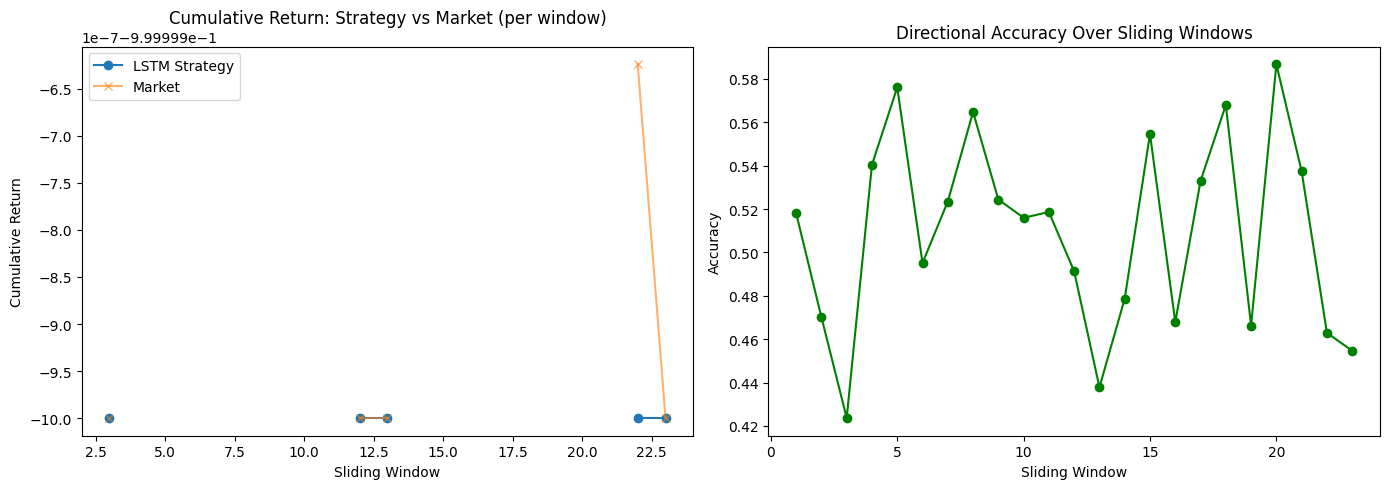

In [8]:
results_df = sliding_window_train_eval(df, top20_features)

# Summary statistics of results
print(results_df[['accuracy','precision','recall','f1','cum_strategy_return','cum_market_return','sharpe_ratio']].describe())

# Plot cumulative returns
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(results_df['window'], results_df['cum_strategy_return'], marker='o', label='LSTM Strategy')
plt.plot(results_df['window'], results_df['cum_market_return'], marker='x', label='Market', alpha=0.6)
plt.title('Cumulative Return: Strategy vs Market (per window)')
plt.xlabel('Sliding Window')
plt.ylabel('Cumulative Return')
plt.legend()

# Plot accuracy over windows
plt.subplot(1,2,2)
plt.plot(results_df['window'], results_df['accuracy'], marker='o', color='green')
plt.title('Directional Accuracy Over Sliding Windows')
plt.xlabel('Sliding Window')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


# 8. LSTM Model Training with Sliding Window Summary

* We built and trained an LSTM model from scratch using the top 20 features identified by XGBoost.

* A realistic sliding window walk-forward approach was used for model training and validation to simulate live trading conditions.

* Early stopping was implemented to reduce overfitting and improve model generalization.

* Key classification metrics (accuracy, precision, recall, F1) and financial metrics (cumulative returns, Sharpe ratio) were tracked across 23 rolling windows.

* While directional accuracy hovered near chance (~50%), the model showed some potential with positive average Sharpe ratios.

* However, cumulative return metrics revealed significant instability and extreme outliers in many windows.

* We added robust checks to detect and flag these outlier windows to maintain metric integrity.

These results highlight the challenge of predictive modeling in financial markets and the need for further model tuning and robustness testing.